In [ ]:
# Now we can import Spark-related libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
import requests
from io import StringIO
import pandas as pd
from google.colab import drive

# Mount Google Drive to access files
drive.mount('/content/drive')

# Start Spark Session
spark = SparkSession.builder \
    .appName("MapReduce SVM") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryoserializer.buffer.max", "2000m") \
    .getOrCreate()

# Đọc file CSV vào DataFrame
file_path = "/content/drive/MyDrive/Big data/df_final.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.show()

Mounted at /content/drive
+----------+-------------------------------------+-------------------------------------+--------------------------+--------------------------+---------------+
|is_injured|contributing_factor_vehicle_1_encoded|contributing_factor_vehicle_2_encoded|vehicle_type_code1_encoded|vehicle_type_code2_encoded|borough_encoded|
+----------+-------------------------------------+-------------------------------------+--------------------------+--------------------------+---------------+
|         0|                                 36.0|                                 21.0|                      32.0|                      37.0|            3.0|
|         1|                                  7.0|                                 21.0|                      32.0|                      37.0|            0.0|
|         1|                                  7.0|                                 21.0|                      32.0|                      38.0|            1.0|
|         0|        

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import DenseVector
import numpy as np
from pyspark.ml.feature import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

# Encode 'is_injured' as 1 or -1
df = df.withColumn("encoded_is_injured", when(col('is_injured') == 1, 1).otherwise(-1))


# Define feature columns (all except 'is_injured')
feature_columns = [
    "contributing_factor_vehicle_1_encoded", "contributing_factor_vehicle_2_encoded",
    "vehicle_type_code1_encoded", "vehicle_type_code2_encoded", "borough_encoded"
]

# Dùng VectorAssembler để kết hợp các feature thành 1 cột duy nhất
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

#Chuẩn hóa vector đặc trưng (features) để đảm bảo tất cả các đặc trưng có cùng tỷ lệ (mean = 0, std = 1)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
df = scaler.fit(df).transform(df)

df.show()

# Split the data into initial train and test sets
train, test = df.randomSplit([0.8, 0.2], seed=42)

# Further split train into train_sub and validation
train_sub, validation = train.randomSplit([0.8, 0.2], seed=42)

# Convert train_sub and validation DataFrames to RDDs
# cấu trúc (vector đặc trưng, nhãn)
train_sub_rdd = train_sub.rdd.map(lambda row: (np.array(row['scaled_features']), row['encoded_is_injured']))
validation_rdd = validation.rdd.map(lambda row: (np.array(row['scaled_features']), row['encoded_is_injured']))
test_rdd = test.rdd.map(lambda row: (np.array(row['scaled_features']), row['encoded_is_injured']))


+----------+-------------------------------------+-------------------------------------+--------------------------+--------------------------+---------------+------------------+--------------------+--------------------+
|is_injured|contributing_factor_vehicle_1_encoded|contributing_factor_vehicle_2_encoded|vehicle_type_code1_encoded|vehicle_type_code2_encoded|borough_encoded|encoded_is_injured|            features|     scaled_features|
+----------+-------------------------------------+-------------------------------------+--------------------------+--------------------------+---------------+------------------+--------------------+--------------------+
|         0|                                 36.0|                                 21.0|                      32.0|                      37.0|            3.0|                -1|[36.0,21.0,32.0,3...|[1.30800416442327...|
|         1|                                  7.0|                                 21.0|                      32.0|     

In [ ]:
# Updated SVM class and metrics computation
class SVM:
    def __init__(self, n_iters=10, lr=0.001, lambda_param=0.01):
        self.n_iters = n_iters #Số lần lặp (epoch).
        self.lr = lr
        self.lambda_param = lambda_param #Tham số regularization.
        self.w = None
        self.b = 0.0

    def fit(self, rdd):
        num_features = len(rdd.first()[0])
        self.w = np.zeros(num_features)

        for _ in range(self.n_iters):
            # Map and reduce steps for gradient descent
            gradients = rdd.map(self._compute_gradients)
            grad_w, grad_b = gradients.reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]))

            # Update weights and bias
            self.w -= self.lr * (grad_w + self.lambda_param * self.w)
            self.b -= self.lr * grad_b

    def _compute_gradients(self, data_point):
        x, y = data_point
        condition = y * (np.dot(self.w, x) - self.b) >= 1
        if condition:
            grad_w = np.zeros_like(self.w)
            grad_b = 0.0
        else:
            grad_w = -y * x
            grad_b = -y
        return grad_w, grad_b

    def predict(self, rdd):
        return rdd.map(lambda x: (x[1], 1 if np.dot(self.w, x[0]) - self.b >= 0 else -1))

def calculate_metrics(predictions_rdd):
    # Compute TP, FP, FN, TN using RDD transformations
    metrics_rdd = predictions_rdd.map(lambda x: (
        1 if x[0] == 1 and x[1] == 1 else 0,  # TP
        1 if x[0] == -1 and x[1] == 1 else 0,  # FP
        1 if x[0] == 1 and x[1] == -1 else 0,  # FN
        1 if x[0] == -1 and x[1] == -1 else 0   # TN
    ))
    tp, fp, fn, tn = metrics_rdd.reduce(lambda a, b: tuple(map(sum, zip(a, b))))

    # Calculate metrics
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    confusion_matrix = np.array([[tp, fn], [fp, tn]])

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score,
        "cm": confusion_matrix
    }

def plot_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(6, 6))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix SVM")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Predicted Positive", "Predicted Negative"], rotation=45)
    plt.yticks(tick_marks, ["Actual Positive", "Actual Negative"])

    # Annotate confusion matrix
    for i in range(2):
        for j in range(2):
            plt.text(j, i, confusion_matrix[i, j],
                     horizontalalignment="center",
                     color="white" if confusion_matrix[i, j] > confusion_matrix.max() / 2. else "black")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

In [ ]:
# Define hyperparameter grid
learning_rates = [0.001, 0.01, 0.1]
lambda_params = [0.001, 0.01, 0.1]
num_iters = [50, 100, 150]

# Containers for results
grid_search_results = []
best_params = None
best_f1_score = 0
best_model = None

# Iterate over all combinations of hyperparameters
for lr, lambda_param, n_iters in product(learning_rates, lambda_params, num_iters):
    print(f"Testing: lr={lr}, lambda={lambda_param}, n_iters={n_iters}")
    clf = SVM(n_iters=n_iters, lr=lr, lambda_param=lambda_param)
    clf.fit(train_sub_rdd)

    # Evaluate on the validation set
    val_predictions_rdd = clf.predict(validation_rdd)
    val_metrics = calculate_metrics(val_predictions_rdd)
    f1_score = val_metrics["F1-Score"]

    # Store the results
    grid_search_results.append((lr, lambda_param, n_iters, f1_score))

    # Track the best hyperparameters
    if f1_score > best_f1_score:
        best_f1_score = f1_score
        best_params = {"lr": lr, "lambda_param": lambda_param, "n_iters": n_iters}
        best_model = clf

# Display the best hyperparameters
print(f"Best Hyperparameters: {best_params}")
print(f"Best F1-Score: {best_f1_score:.4f}")

Testing: lr=0.001, lambda=0.001, n_iters=50
Testing: lr=0.001, lambda=0.001, n_iters=100
Testing: lr=0.001, lambda=0.001, n_iters=150
Testing: lr=0.001, lambda=0.01, n_iters=50
Testing: lr=0.001, lambda=0.01, n_iters=100
Testing: lr=0.001, lambda=0.01, n_iters=150
Testing: lr=0.001, lambda=0.1, n_iters=50
Testing: lr=0.001, lambda=0.1, n_iters=100
Testing: lr=0.001, lambda=0.1, n_iters=150
Testing: lr=0.01, lambda=0.001, n_iters=50
Testing: lr=0.01, lambda=0.001, n_iters=100
Testing: lr=0.01, lambda=0.001, n_iters=150
Testing: lr=0.01, lambda=0.01, n_iters=50
Testing: lr=0.01, lambda=0.01, n_iters=100
Testing: lr=0.01, lambda=0.01, n_iters=150
Testing: lr=0.01, lambda=0.1, n_iters=50
Testing: lr=0.01, lambda=0.1, n_iters=100
Testing: lr=0.01, lambda=0.1, n_iters=150
Testing: lr=0.1, lambda=0.001, n_iters=50
Testing: lr=0.1, lambda=0.001, n_iters=100
Testing: lr=0.1, lambda=0.001, n_iters=150
Testing: lr=0.1, lambda=0.01, n_iters=50
Testing: lr=0.1, lambda=0.01, n_iters=100
Testing: lr=

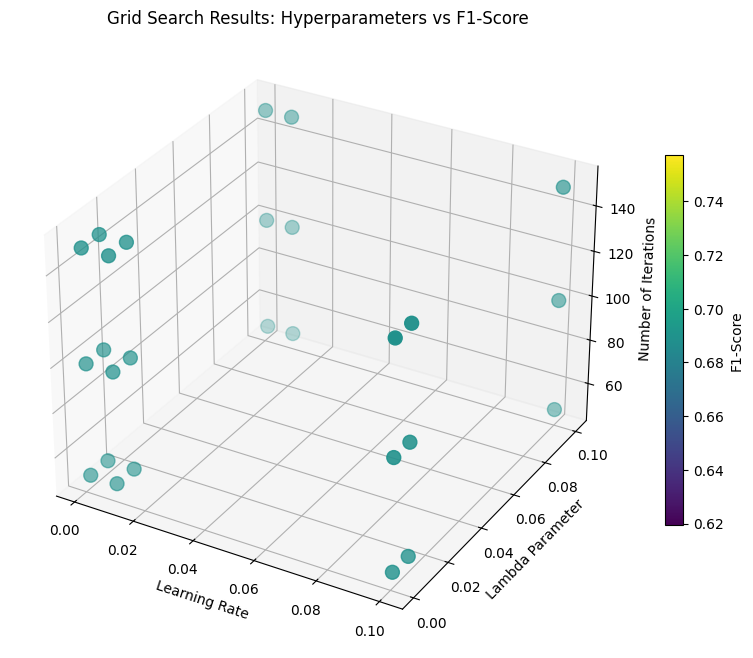

In [ ]:
# Convert results into a numpy array for visualization
results_array = np.array(grid_search_results)
learning_rates = results_array[:, 0]
lambda_params = results_array[:, 1]
n_iters = results_array[:, 2]
f1_scores = results_array[:, 3]

# Create a 3D scatter plot to visualize the grid search
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(learning_rates, lambda_params, n_iters, c=f1_scores, cmap='viridis', s=100)
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Lambda Parameter")
ax.set_zlabel("Number of Iterations")
ax.set_title("Grid Search Results: Hyperparameters vs F1-Score")

# Add color bar to represent F1-Score
colorbar = plt.colorbar(scatter, ax=ax, shrink=0.6)
colorbar.set_label("F1-Score")

plt.show()

# KO DÙNG HÀM

Accuracy: 0.5284
Precision: 0.5284
Recall: 1.0000
F1-Score: 0.6914


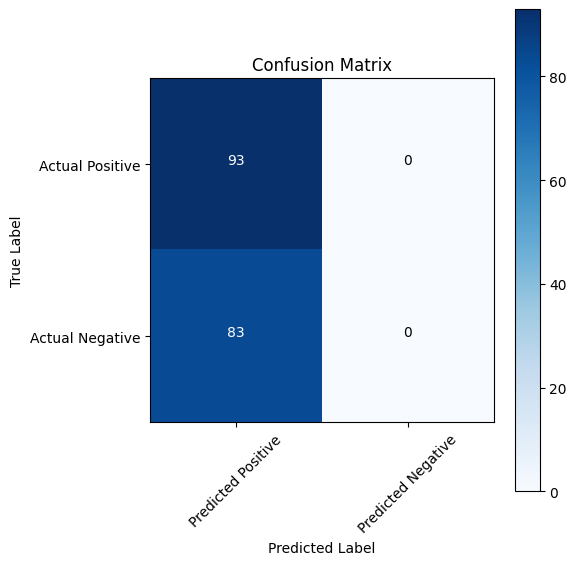

In [ ]:
# Test the best model on the test set
test_predictions_rdd = best_model.predict(test_rdd)
test_metrics = calculate_metrics(test_predictions_rdd)

# Display test metrics
for metric, value in test_metrics.items():
    if metric != "cm":
        print(f"{metric}: {value:.4f}")

# Plot confusion matrix for test set
plot_confusion_matrix(test_metrics["cm"])

In [ ]:
# predicted_count = predictions.count()
# print(f"Number of predictions: {predicted_count}")


# DÙNG HÀM

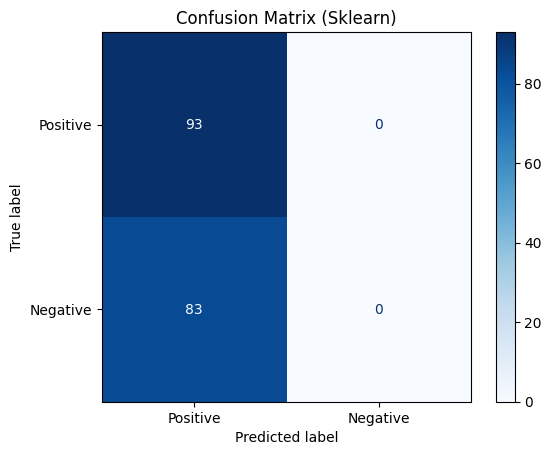

In [ ]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# y_true = np.array(test_predictions_rdd.map(lambda x: x[0]).collect())
# y_pred = np.array(test_predictions_rdd.map(lambda x: x[1]).collect())

# cm = confusion_matrix(y_true, y_pred, labels=[1, -1])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Negative"])
# disp.plot(cmap=plt.cm.Blues)
# plt.title("Confusion Matrix (Sklearn)")
# plt.show()


# **Huấn luyện song song:**
map:
Tính gradient riêng lẻ cho từng điểm dữ liệu (song song hóa trên các phân vùng RDD).

reduce:
Tổng hợp gradient từ các phân vùng để cập nhật trọng số (w) và bias (b).




# **Ưu điểm:**
Xử lý dữ liệu lớn với khả năng phân tán.
Khả năng mở rộng trên các cụm Spark.